# Dataset preparation and updating with new features
---
The notebook provides snippet code which is used to create and clean up the dataset, calculate new important features and estimate the significance of all features.

(The finalised and updated dataset can be found on a shared data directory named ‘df_new.zip’)

# Requirements

In [4]:
! pip install biopython
! pip install biopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 1.8 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import torch
import pandas as pd
from biopandas.pdb import PandasPdb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from Bio.PDB import DSSP, HSExposureCB, PPBuilder, is_aa, NeighborSearch
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.SeqUtils import seq1
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from timeit import default_timer as timer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score


# Dataset creation and directory list

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
path_ring = 'drive/MyDrive/SB_project/features_ring/'
path_pdb = 'drive/MyDrive/SB_project/pdb_files/' # Folder with pdb files matching "pdb_id" column of original dataset

In [10]:
dfs = []
for filename in os.listdir(path_ring):
    dfs.append(pd.read_csv(path_ring + filename, sep='\t'))
df = pd.concat(dfs)

df.dropna(inplace=True)
y = df['Interaction'].astype('category')

# Add Feature: CA-CA Distances between source & target residues

In [12]:
from Bio import PDB
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed


parser = PDB.PDBParser(QUIET=True)


def get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path):
    """Calculates CA-CA distance between two residues in a PDB file"""

    structure = parser.get_structure(pdb_id, pdb_file_path)
    model = structure[0]


    try: # locate source- & target-chains
        s_chain = model[s_ch]
        t_chain = model[t_ch]
    except KeyError:
        raise ValueError(f"Chain {s_ch} or {t_ch} not found in structure {pdb_id}")


    try: # locate source- & target-residues
        s_residue = s_chain[s_resi]
        t_residue = t_chain[t_resi]
    except KeyError:
        raise ValueError(f"Residue {s_resi} or {t_resi} not found in chains {s_ch} or {t_ch}")


    try: # locate alpha carbons
        s_ca = s_residue['CA']
        t_ca = t_residue['CA']
    except KeyError:
        raise ValueError(f"Alpha-carbon not found in residue {s_resi} or {t_resi}")


    s_ca_coord = s_ca.get_coord()
    t_ca_coord = t_ca.get_coord()

    distance = np.linalg.norm(s_ca_coord - t_ca_coord)

    return distance


def process_row(index, row, pdb_directory):

    pdb_id = row['pdb_id']
    s_resi = row['s_resi']
    t_resi = row['t_resi']
    s_ch = row['s_ch']
    t_ch = row['t_ch']

    pdb_file_path = os.path.join(pdb_directory, f'{pdb_id}.pdb')

    if not os.path.isfile(pdb_file_path):
        print(f"File {pdb_file_path} does not exist.")
        return None

    try:
        distance = get_residue_distance(pdb_id, s_resi, t_resi, s_ch, t_ch, pdb_file_path)
        return distance
    except Exception as e:
        print(f"Error processing {pdb_id} (row {index}): {e}")
        return None


def calculate_distances_parallel(df, pdb_directory, n_jobs=-1):
    # Use Parallel to process each row in the dataframe in parallel
    ca_distances = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(index, row, pdb_directory) for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows")
    )

    # Add the result to the dataframe
    df['CA_CA_distance'] = ca_distances
    return df


In [ ]:
# Compute CA-CA distances, add it as a feature to the dataframe
df = calculate_distances_parallel(df, path_pdb, n_jobs=-1)
df.dropna(inplace=True)

# Save the updated dataframe to a pickle file or to a csv file if you prefer
df.to_pickle('drive/MyDrive/SB_project/df_new.pkl')
# df.to_csv('drive/MyDrive/SB_project/df_new.csv', index=False)


# Add Feature: Sequence Neighbors (left/right) Aminoacid Type

In [14]:
from Bio import PDB
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import os

def compute_neighbors(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb):

    pdb_file = path_pdb + f"{pdb_id}.pdb"

    # Initialize variables for source (s_) and target (t_) residues
    s_prev_resn, s_prev_phi, s_prev_psi = [None]*3, [None]*3, [None]*3
    s_next_resn, s_next_phi, s_next_psi = [None]*3, [None]*3, [None]*3

    t_prev_resn, t_prev_phi, t_prev_psi = [None]*3, [None]*3, [None]*3
    t_next_resn, t_next_phi, t_next_psi = [None]*3, [None]*3, [None]*3

    if not os.path.isfile(pdb_file):
        return {
            's_1_prev_resn': s_prev_resn[0], 's_1_prev_phi': s_prev_phi[0], 's_1_prev_psi': s_prev_psi[0],
            's_2_prev_resn': s_prev_resn[1], 's_2_prev_phi': s_prev_phi[1], 's_2_prev_psi': s_prev_psi[1],
            's_3_prev_resn': s_prev_resn[2], 's_3_prev_phi': s_prev_phi[2], 's_3_prev_psi': s_prev_psi[2],

            's_1_next_resn': s_next_resn[0], 's_1_next_phi': s_next_phi[0], 's_1_next_psi': s_next_psi[0],
            's_2_next_resn': s_next_resn[1], 's_2_next_phi': s_next_phi[1], 's_2_next_psi': s_next_psi[1],
            's_3_next_resn': s_next_resn[2], 's_3_next_phi': s_next_phi[2], 's_3_next_psi': s_next_psi[2]
        }, {
            't_1_prev_resn': t_prev_resn[0], 't_1_prev_phi': t_prev_phi[0], 't_1_prev_psi': t_prev_psi[0],
            't_2_prev_resn': t_prev_resn[1], 't_2_prev_phi': t_prev_phi[1], 't_2_prev_psi': t_prev_psi[1],
            't_3_prev_resn': t_prev_resn[2], 't_3_prev_phi': t_prev_phi[2], 't_3_prev_psi': t_prev_psi[2],

            't_1_next_resn': t_next_resn[0], 't_1_next_phi': t_next_phi[0], 't_1_next_psi': t_next_psi[0],
            't_2_next_resn': t_next_resn[1], 't_2_next_phi': t_next_phi[1], 't_2_next_psi': t_next_psi[1],
            't_3_next_resn': t_next_resn[2], 't_3_next_phi': t_next_phi[2], 't_3_next_psi': t_next_psi[2],
        }

    # Load structure using PDBParser
    structure = PDB.PDBParser(QUIET=True).get_structure(pdb_id, pdb_file)

    ppb = PDB.PPBuilder()

    for model in structure:
        for chain in model:
            if chain.id == s_ch or chain.id == t_ch:
                # Build the polypeptide for the current chain
                polypeptides = ppb.build_peptides(chain)

                # For each polypeptide in the chain
                for poly in polypeptides:
                    phi_psi = poly.get_phi_psi_list()  # Returns list of tuples (phi, psi)
                    for i, residue in enumerate(poly):
                        res_id = residue.id[1]

                        # For the source chain s_ch
                        if chain.id == s_ch:
                            if res_id == s_resi - 3:
                                s_prev_resn[2], s_prev_phi[2], s_prev_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi - 2:
                                s_prev_resn[1], s_prev_phi[1], s_prev_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi - 1:
                                s_prev_resn[0], s_prev_phi[0], s_prev_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 1:
                                s_next_resn[0], s_next_phi[0], s_next_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 2:
                                s_next_resn[1], s_next_phi[1], s_next_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == s_resi + 3:
                                s_next_resn[2], s_next_phi[2], s_next_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]

                        # For the target chain t_ch
                        if chain.id == t_ch:
                            if res_id == t_resi - 3:
                                t_prev_resn[2], t_prev_phi[2], t_prev_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi - 2:
                                t_prev_resn[1], t_prev_phi[1], t_prev_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi - 1:
                                t_prev_resn[0], t_prev_phi[0], t_prev_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 1:
                                t_next_resn[0], t_next_phi[0], t_next_psi[0] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 2:
                                t_next_resn[1], t_next_phi[1], t_next_psi[1] = residue.resname, phi_psi[i][0], phi_psi[i][1]
                            elif res_id == t_resi + 3:
                                t_next_resn[2], t_next_phi[2], t_next_psi[2] = residue.resname, phi_psi[i][0], phi_psi[i][1]

    # Return the data for 3 neighbors on both sides for both source and target residues
    return {
        's_1_prev_resn': s_prev_resn[0], 's_1_prev_phi': s_prev_phi[0], 's_1_prev_psi': s_prev_psi[0],
        's_2_prev_resn': s_prev_resn[1], 's_2_prev_phi': s_prev_phi[1], 's_2_prev_psi': s_prev_psi[1],
        's_3_prev_resn': s_prev_resn[2], 's_3_prev_phi': s_prev_phi[2], 's_3_prev_psi': s_prev_psi[2],

        's_1_next_resn': s_next_resn[0], 's_1_next_phi': s_next_phi[0], 's_1_next_psi': s_next_psi[0],
        's_2_next_resn': s_next_resn[1], 's_2_next_phi': s_next_phi[1], 's_2_next_psi': s_next_psi[1],
        's_3_next_resn': s_next_resn[2], 's_3_next_phi': s_next_phi[2], 's_3_next_psi': s_next_psi[2]
    }, {
        't_1_prev_resn': t_prev_resn[0], 't_1_prev_phi': t_prev_phi[0], 't_1_prev_psi': t_prev_psi[0],
        't_2_prev_resn': t_prev_resn[1], 't_2_prev_phi': t_prev_phi[1], 't_2_prev_psi': t_prev_psi[1],
        't_3_prev_resn': t_prev_resn[2], 't_3_prev_phi': t_prev_phi[2], 't_3_prev_psi': t_prev_psi[2],

        't_1_next_resn': t_next_resn[0], 't_1_next_phi': t_next_phi[0], 't_1_next_psi': t_next_psi[0],
        't_2_next_resn': t_next_resn[1], 't_2_next_phi': t_next_phi[1], 't_2_next_psi': t_next_psi[1],
        't_3_next_resn': t_next_resn[2], 't_3_next_phi': t_next_phi[2], 't_3_next_psi': t_next_psi[2],
    }

def process_row(row, path_pdb):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']
    s_resi = row['s_resi']
    t_resi = row['t_resi']

    return compute_neighbors(pdb_id, s_ch, s_resi, t_ch, t_resi, path_pdb)


def process_dataset(df, path_pdb):

    # Accumulate results
    results = Parallel(n_jobs=-1)(
        delayed(process_row)(row, path_pdb) for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Dataset")
    )

    # Check for None in results
    valid_results = [(s, t) if s is not None and t is not None else ({}, {}) for s, t in results]

    if len(valid_results) != len(results):
        print(f"Found {len(results) - len(valid_results)} invalid results (None or bad pairs).")

    # Extract results
    s_neighbors, t_neighbors = zip(*results)

    # Convert results into df
    s_df = pd.DataFrame(s_neighbors)
    t_df = pd.DataFrame(t_neighbors)

    neighbor_df = pd.concat([s_df, t_df], axis=1)

    # Reset indices to avoid mismatches
    df.reset_index(drop=True, inplace=True)
    neighbor_df.reset_index(drop=True, inplace=True)

    new_df = pd.concat([df, neighbor_df], axis=1)

    return new_df


In [ ]:
# Load the dataset with new previously computed features or use the original one
df = pd.read_pickle('drive/MyDrive/SB_project/df_new.pkl')
# df = pd.read_csv('drive/MyDrive/SB_project/df_new.csv')

# Compute left and right neighbors in a sequence and add them as features to the dataframe
df = process_dataset(df, path_pdb)
df.dropna(inplace=True)

# Save the updated dataframe to a pickle file or to a csv file if you prefer
df.to_pickle('drive/MyDrive/SB_project/df_new.pkl')
# df.to_csv('drive/MyDrive/SB_project/df_new.csv', index=False)


# Add Feature: Lengths of sequences

In [16]:
# Load the dataset with new previously computed features or use the original one
df = pd.read_pickle('drive/MyDrive/SB_project/df_new.pkl')
# df = pd.read_csv('drive/MyDrive/SB_project/df_new.csv')

In [ ]:
import pandas as pd
from Bio.PDB import PDBParser
from collections import defaultdict
import os  # To check if the file exists
from tqdm import tqdm  # Import tqdm for progress bar

def get_chain_length(structure, chain_id):
    chain = structure[0][chain_id]  # Assuming only one model (0) in the structure
    return len([residue for residue in chain.get_residues() if residue.id[0] == ' '])  # Only count standard residues

# Dictionary to cache chain lengths: {('pdb_id', 'chain_id'): chain_length}
chain_length_cache = defaultdict(int)

parser = PDBParser()

# Iterate through the DataFrame with a progress bar
prev_pdb_id = None  # Keep track of the previous PDB ID to optimize PDB file parsing
structure = None  # Store the parsed PDB structure for reuse

df['s_chain_length'] = None
df['t_chain_length'] = None

for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc='Processing Rows', unit='row'):
    pdb_id = row['pdb_id']
    s_ch = row['s_ch']
    t_ch = row['t_ch']

    pdb_file = f"{path_pdb}/{pdb_id}.pdb"

    if not os.path.exists(pdb_file):
        df.at[idx, 's_chain_length'] = None
        df.at[idx, 't_chain_length'] = None
        continue  # Skip to the next row

    if pdb_id != prev_pdb_id:
        structure = parser.get_structure(pdb_id, pdb_file)
        prev_pdb_id = pdb_id

    if (pdb_id, s_ch) not in chain_length_cache:
        chain_length_cache[(pdb_id, s_ch)] = get_chain_length(structure, s_ch)

    if s_ch == t_ch:
        df.at[idx, 's_chain_length'] = chain_length_cache[(pdb_id, s_ch)]
        df.at[idx, 't_chain_length'] = chain_length_cache[(pdb_id, s_ch)]
    else:
        if (pdb_id, t_ch) not in chain_length_cache:
            chain_length_cache[(pdb_id, t_ch)] = get_chain_length(structure, t_ch)

        df.at[idx, 's_chain_length'] = chain_length_cache[(pdb_id, s_ch)]
        df.at[idx, 't_chain_length'] = chain_length_cache[(pdb_id, t_ch)]

# Resulting df will now have 's_chain_length' and 't_chain_length' columns with None where PDB files are missing
df.dropna(inplace=True)
df


In [ ]:
# Save the updated dataframe to a pickle file or to a csv file if you prefer
df.to_pickle('drive/MyDrive/SB_project/df_new.pkl')
# df.to_csv('drive/MyDrive/SB_project/df_new.csv', index=False)

# Feature Importance
This part performs feature importance analysis using a Random Forest Classifier on a sample of data from a larger dataset.

In [26]:
# Load the dataset with new previously computed features to check if the new features are significant for the future model
df = pd.read_pickle('drive/MyDrive/SB_project/df_new.pkl')

In [29]:
#Label Encoding: the data transormation, s.t. all features are numerical
label_encoder = LabelEncoder()

def encode_object_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].astype(str)
            df[column] = label_encoder.fit_transform(df[column])
    return df
df = encode_object_columns(df)
df['s_chain_length'].unique()

array([422, 277, 124, 423, 240, 356, 123, 224, 155, 230, 152, 239, 445,
       226, 385, 513, 259, 284,  98,  58,  83, 308, 144, 303,  72,  43,
       283, 301, 306, 175, 105,  46,  49,  79, 299, 174, 311, 298, 217,
       519, 173, 390,  71, 760, 482, 522, 477, 475, 222, 499, 726, 225,
       227, 223, 228, 539, 221, 497, 377, 535, 540, 269, 456, 556, 537,
       288,  80,  41,  84, 104, 514, 183, 164, 362, 363, 361, 351, 350])

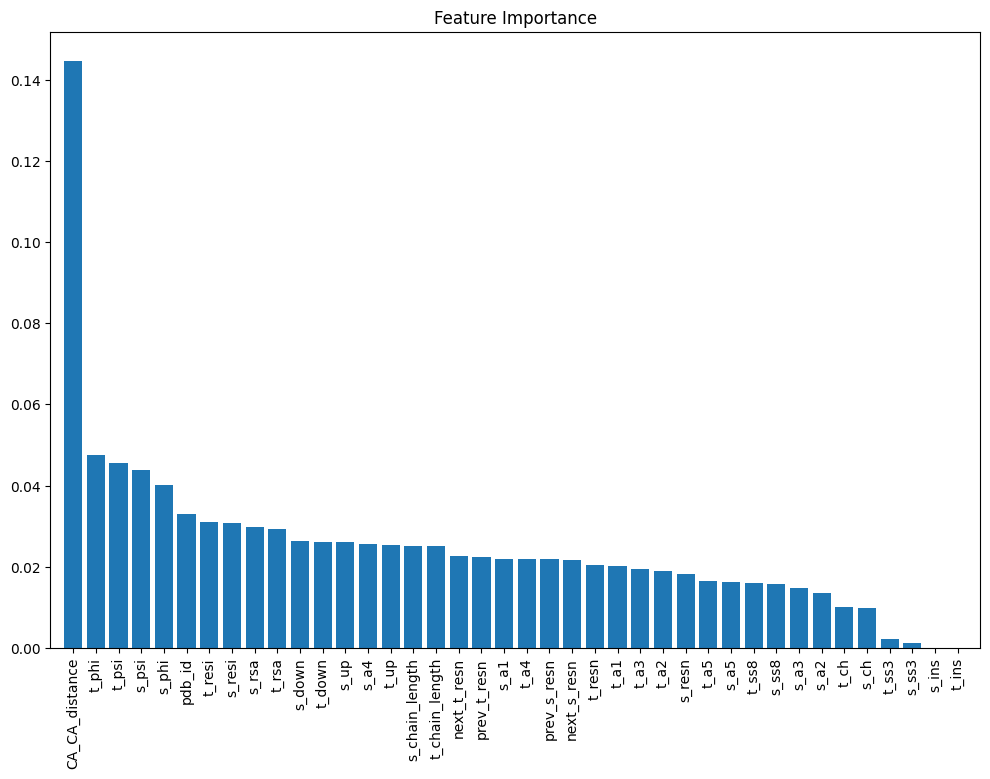

In [31]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Sample a subset of the data
sample_size = 500000
df_sample = df.sample(n=sample_size, random_state=42)

X_sample = df_sample.drop(columns=['Interaction'])
y_sample = df_sample['Interaction']

# Convert labels to one-hot encoding if necessary and then back to labels for Random Forest
y_sample = pd.get_dummies(y_sample)  # One-hot encode if needed
y_sample_labels = y_sample.values.argmax(axis=1)  # Convert back to labels

rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)  # Reduced parameters
rf.fit(X_sample, y_sample_labels)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_sample.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sample.shape[1]), X_sample.columns[indices], rotation=90)
plt.xlim([-1, X_sample.shape[1]])
plt.show()


XGBoost Accuracy: 0.9695


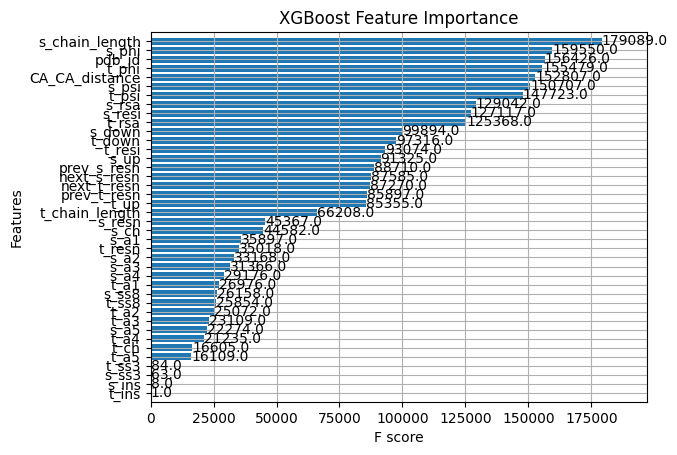

In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define and train the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=20, random_state=42)
xgb_model.fit(X_sample, y_sample_labels)

# Predict and evaluate
y_pred = xgb_model.predict(X_sample)
print(f"XGBoost Accuracy: {accuracy_score(y_sample_labels, y_pred):.4f}")

# Feature importance for XGBoost
xgb.plot_importance(xgb_model, max_num_features=40, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()